# Capstone Project - The Battle of Neighbourhoods

## The business problem and the background of this project

The aim of this project is to find the best location in Central London to open a new Real Estate Office. London is a big and vibrant city, where lots of people dream to live in. Property in London could be very expensive, but there are many affluent people from all over the world looking to buy property either for personal use or as an investment. The real estate market moves fast and there are a number of real estate agencies, but we are planning to open an exclusive luxurious agency and we will try to find the best location for it based on property prices in the neighbourhood and the number of real estate agencies as we don't want an impression that our agency is just one of many.

## Data and how it is going to be used to solve the problem

The UK government openly shares Price Paid Data and it includes information on all property sales in England and Wales that are sold for value and are lodged for registration. This data could be donloaded from [here](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads#march-2021-data-current-month). Data contains HM Land Registry data © Crown copyright and database right 2021. This data is licensed under the Open Government Licence v3.0. I am going to use property sales in 2020 to segment neighbourhoods in Central London (defined by post codes starting with EC or WC) based on property price to choose most luxurious areas.

FreeMapTools provides a list of UK post codes and their geographical coordinates latitude and longitude. We are going to use them to plot neighbourhoods with sold properties on a map. This data could be found [here](https://www.freemaptools.com/download-uk-postcode-lat-lng.htm).

Once I had the coordinates of each neighbourhood in Central London with some properties sold, I used a 1km radius from the centre point of each neighbourhood, defined by a postcode, to locate all Real Estate Offices nearby using FourSquare data.

I then counted the number of real estate offices in each neighbourhood and average property price in each neighbourhood. A k-cluster analysis was done following that to find the best areas for the new real estate office targeting premium property sellers and buyers.

## Methodology

### Data preparation and exploration

#### Property sales and geolocation data

Import libraries.

In [1]:
import pandas as pd
import requests
import zipfile
import geocoder
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library
import numpy as np # library to handle data in a vectorized manner
from sklearn import datasets
from sklearn.metrics import silhouette_samples,silhouette_score

Download property sales data for England and Wales in 2020.

The data file contains the following information:
- id - A reference number which is generated automatically recording each published sale. The number is unique and will change each time a sale is recorded.
- price - sale price stated on the transfer deed.
- date - date when the sale was completed, as stated on the transfer deed.
- postcode - postcode used at the time of the original transaction.
- type - proverty type (D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other)
- age - Old/New (indicates the age of the property and applies to all price paid transactions, residential and non-residential). Y = a newly built property, N = an established residential building
- duration - relates to the tenure: F = Freehold, L= Leasehold etc.
- PAON - Primary Addressable Object Name. Typically the house number or name.
- SAON - Secondary Addressable Object Name. Where a property has been divided into separate units (for example, flats), the PAON (above) will identify the building and a SAON will be specified that identifies the separate unit/flat.
- Street
- Locality
- City - Town or City
- Borough
- County
- PPD_Category - indicates the type of Price Paid transaction. (A = Standard Price Paid entry, includes single residential property sold for value; B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets (where they can be identified by a Mortgage) and transfers to non-private individuals.)
- Record_Status - monthly file only	Indicates additions, changes and deletions to the records.(A = Addition; C = Change; D = Delete).

In [2]:
price_data = pd.read_csv("http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-2020.csv", 
                         header=0, 
                         names=['id','price','date','postcode','type','age','duration','PAON','SAON','Street','Locality','City','Borough','County','PPD_Category','Record_Status'])
price_data.head()

,id,price,date,postcode,type,age,duration,PAON,SAON,Street,Locality,City,Borough,County,PPD_Category,Record_Status
0,{B5755FFD-E94F-7D01-E053-6C04A8C036B6},250000,2020-09-02 00:00,DE56 1HJ,D,N,F,31,NaN,DOVEDALE CRESCENT,NaN,BELPER,AMBER VALLEY,DERBYSHIRE,A,A
1,{B5755FFD-E950-7D01-E053-6C04A8C036B6},135000,2020-10-23 00:00,DE4 2GJ,T,N,F,TORFIELD COTTAGES,13,GREEN LANE,DARLEY DALE,MATLOCK,DERBYSHIRE DALES,DERBYSHIRE,A,A
2,{B5755FFD-E951-7D01-E053-6C04A8C036B6},180000,2020-11-05 00:00,S18 8PL,S,N,F,11,NaN,ENNERDALE CLOSE,DRONFIELD WOODHOUSE,DRONFIELD,NORTH EAST DERBYSHIRE,DERBYSHIRE,A,A
3,{B5755FFD-E952-7D01-E053-6C04A8C036B6},250000,2020-09-11 00:00,DE4 3SH,S,N,F,3,NaN,HILLSIDE GARDENS,NaN,MATLOCK,DERBYSHIRE DALES,DERBYSHIRE,A,A
4,{B5755FFD-E953-7D01-E053-6C04A8C036B6},148000,2020-09-21 00:00,S18 1PB,S,N,L,37,NaN,SUMMERWOOD LANE,NaN,DRONFIELD,NORTH EAST DERBYSHIRE,DERBYSHIRE,A,A


Let's look at the unique County names to narrow down the property sales to London only.

In [3]:
price_data['County'].unique()

array(['DERBYSHIRE', 'CITY OF DERBY', 'GREATER LONDON', 'EAST SUSSEX',
       'BRIGHTON AND HOVE', 'ESSEX', 'SOUTHEND-ON-SEA', 'THURROCK',
       'GREATER MANCHESTER', 'WEST MIDLANDS', 'HAMPSHIRE', 'SOUTHAMPTON',
       'ISLE OF WIGHT', 'NORTH EAST LINCOLNSHIRE', 'NORTH LINCOLNSHIRE',
       'EAST RIDING OF YORKSHIRE', 'CITY OF KINGSTON UPON HULL',
       'GLOUCESTERSHIRE', 'SOUTH GLOUCESTERSHIRE',
       'BOURNEMOUTH, CHRISTCHURCH AND POOLE', 'DORSET', 'KENT', 'MEDWAY',
       'COUNTY DURHAM', 'DARLINGTON', 'HARTLEPOOL', 'TYNE AND WEAR',
       'STOCKTON-ON-TEES', 'CORNWALL', 'BLACKBURN WITH DARWEN',
       'WARRINGTON', 'BLACKPOOL', 'LANCASHIRE', 'HALTON', 'CHESHIRE EAST',
       'CHESHIRE WEST AND CHESTER', 'CITY OF PETERBOROUGH',
       'CAMBRIDGESHIRE', 'REDCAR AND CLEVELAND', 'MIDDLESBROUGH',
       'CUMBRIA', 'DENBIGHSHIRE', 'CAERPHILLY', 'MERTHYR TYDFIL',
       'BRIDGEND', 'NEWPORT', 'CARDIFF', 'PEMBROKESHIRE', 'MONMOUTHSHIRE',
       'GWYNEDD', 'SWANSEA', 'POWYS', 'BLAENAU GW

We are going to create a subset of property sales data and name it _lon_price_subset_:
- County is Greater London and City is London to select only sales in London area
- Record Status is A as we are interested in new additions to the sales list only and not changes or deletions
- Postcodes starting with WC or EC to select Central London locations only
- Prices are greater than 5000 to filter out data that doesn't make sense pricewise.
- Select only the information we need for segmentation and clustering - id, price, postcode, type and Borough


In [4]:
Lon_price_data=price_data[(price_data['County'] == 'GREATER LONDON')&(price_data['Record_Status'] == 'A')&(price_data['price'] >= 5000)&(price_data['City'] == 'LONDON')&(price_data['postcode'].str.startswith(("WC","EC")))]
lon_price_subset=Lon_price_data[['id','price','postcode','type','Borough']]
lon_price_subset

,id,price,postcode,type,Borough
13891,{C18F412A-74FE-81A6-E053-6B04A8C0AD18},727300,EC1Y 0AD,F,CITY OF LONDON
17275,{B82222EC-7291-6691-E053-6B04A8C02FB2},480000,EC1V 7NB,F,ISLINGTON
17289,{B82222EC-72A1-6691-E053-6B04A8C02FB2},915000,EC1R 1XT,F,ISLINGTON
19467,{B82222EC-72B0-6691-E053-6B04A8C02FB2},870000,EC2Y 8PQ,F,CITY OF LONDON
20110,{C18F412A-781E-81A6-E053-6B04A8C0AD18},684825,WC1E 6JW,F,CAMDEN
...,...,...,...,...,...
779126,{9FF0D969-6B79-11ED-E053-6C04A8C06383},1669440,EC2A 2FF,F,HACKNEY
779132,{9FF0D969-6BBA-11ED-E053-6C04A8C06383},555750,EC2A 2FB,F,HACKNEY
779133,{9FF0D969-6BCB-11ED-E053-6C04A8C06383},2663520,EC2A 2FG,F,HACKNEY
779139,{9FF0D969-6BF1-11ED-E053-6C04A8C06383},2240370,EC2A 2FG,F,HACKNEY


In [5]:
print("The shape of the London price data is", lon_price_subset.shape)

The shape of the London price data is (1040, 5)


We are going to get latitude and longitude data for each postcode in the UK from FreeMapTools.

In [6]:
postcode_data = pd.read_csv('ukpostcodes.csv')  # https://www.freemaptools.com/download-uk-postcode-lat-lng.htm
postcode_data = postcode_data[['postcode','latitude','longitude']]
postcode_data.head()

,postcode,latitude,longitude
0,AB10 1XG,57.144165,-2.114848
1,AB10 6RN,57.137880,-2.121487
2,AB10 7JB,57.124274,-2.127190
3,AB11 5QN,57.142701,-2.093295
4,AB11 6UL,57.137547,-2.112233


Merge the London property sales data subset with the geo data (latitude and longitude) to get coordinates for each postcode with property sales.

In [7]:
price_geo_data = lon_price_subset.merge(postcode_data.set_index('postcode'), on='postcode', how='inner')
price_geo_data.head()

,id,price,postcode,type,Borough,latitude,longitude
0,{C18F412A-74FE-81A6-E053-6B04A8C0AD18},727300,EC1Y 0AD,F,CITY OF LONDON,51.523139,-0.095988
1,{C18F412A-740F-81A6-E053-6B04A8C0AD18},1083750,EC1Y 0AD,F,CITY OF LONDON,51.523139,-0.095988
2,{C18F412A-741A-81A6-E053-6B04A8C0AD18},1066750,EC1Y 0AD,F,CITY OF LONDON,51.523139,-0.095988
3,{C18F412A-744C-81A6-E053-6B04A8C0AD18},1397500,EC1Y 0AD,F,CITY OF LONDON,51.523139,-0.095988
4,{C18F412A-7451-81A6-E053-6B04A8C0AD18},815450,EC1Y 0AD,F,CITY OF LONDON,51.523139,-0.095988


In [8]:
print("The shape of the London price data with geographical coordinates is", price_geo_data.shape)

The shape of the London price data with geographical coordinates is (1037, 7)


Three sales were excluded from the new data set as they did not have a postcode in the original dataset and could not be used for further analysis.

Let's get a summary of the newly created dataframe.

In [9]:
price_geo_data.describe(include='all')

,id,price,postcode,type,Borough,latitude,longitude
count,1037,1.037000e+03,1037,1037,1037,1037.000000,1037.000000
unique,1037,NaN,481,4,5,NaN,NaN
top,{A2479555-145F-74C7-E053-6B04A8C0887D},NaN,WC2A 2AT,F,ISLINGTON,NaN,NaN
freq,1,NaN,147,799,267,NaN,NaN
mean,NaN,3.523350e+06,NaN,NaN,NaN,51.521213,-0.105640
std,NaN,1.760576e+07,NaN,NaN,NaN,0.005871,0.014895
min,NaN,5.000000e+03,NaN,NaN,NaN,51.507431,-0.136397
25%,NaN,6.000000e+05,NaN,NaN,NaN,51.515733,-0.116228
50%,NaN,9.300000e+05,NaN,NaN,NaN,51.522031,-0.105987
75%,NaN,1.566330e+06,NaN,NaN,NaN,51.526403,-0.095988


All fields are fully populated and we have a good quality dataset to use for further analysis.

### Visualisation of the sales data and getting real estate offices nearby

In this section, we are going to explore the neighborhoods with property sales in London.

We are going to use geopy library to get the latitude and longitude values of London.
In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>london_explorer</em>, as shown below.

In [10]:
address = 'London, UK'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of London are {}, {}.'.format(latitude, longitude))

The coordinates of London are 51.5073219, -0.1276474.


Create a map of London with sold properties superimposed on top.

In [11]:
# Creating the map of London
map_London = folium.Map(location=[latitude, longitude], zoom_start=13)

# adding markers to map
for latitude, longitude, borough, price in zip(price_geo_data['latitude'], price_geo_data['longitude'], price_geo_data['Borough'], price_geo_data['price']):
    label = '{}, {}'.format(price, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True
        ).add_to(map_London)  
    
map_London

Define Foursquare Credentials and Version

In [15]:

CLIENT_ID = 'JRDPDCRHOV2FDBUCSFNT3YVOS5T5BRZXMYLBK0HYE5JH0VYL' # your Foursquare ID
CLIENT_SECRET = 'A1DW4ADVBR4S2N0EG0BWPJGYKDQGQW5CTJJ0QT4L5ID5EHZ2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


We are going to create a function to get all the venues in Real Estate Office category in London. Real Estate Office category is defined by categoryId=5032885091d4c4b30a586d66.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=5032885091d4c4b30a586d66'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            limit
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Next, we are going to collect the real estate offices in London for each neighborhood (within 1km of each neighbourhood) and create a new dataframe caled _london_venues_1km_. Let's make sure that we include Real Estate offices only.

In [17]:
london_venues_1km = getNearbyVenues(price_geo_data['postcode'], 
                                 price_geo_data['latitude'], 
                                 price_geo_data['longitude'],1000)

In [18]:
london_venues_1km = london_venues_1km[london_venues_1km['Venue Category']=='Real Estate Office']

In [19]:
print("The shape of the London venues data is", london_venues_1km.shape) 

The shape of the London venues data is (13105, 7)


Let's check the resulting dataframe.

In [20]:
london_venues_1km.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,EC1Y 0AD,51.523139,-0.095988,Felicity J Lord estate agents Clerkenwell,51.524567,-0.099469,Real Estate Office
1,EC1Y 0AD,51.523139,-0.095988,"Felicity J Lord letting agents, Clerkenwell",51.524592,-0.099468,Real Estate Office
2,EC1Y 0AD,51.523139,-0.095988,Amdas Management,51.520367,-0.096080,Real Estate Office
3,EC1Y 0AD,51.523139,-0.095988,Foxtons Clerkenwell Estate Agents,51.522775,-0.100654,Real Estate Office
4,EC1Y 0AD,51.523139,-0.095988,Urban Spaces,51.522765,-0.101509,Real Estate Office


Let's create a new dataframe _no_estate_offices_ with the number of real estate offices near each neighbourhood and get a summary to better understand the distribution of the number of venues close to sold objects.

In [22]:
no_estate_offices=london_venues_1km.groupby('Neighbourhood').count()
no_estate_offices.index.name = 'Neighbourhood'
no_estate_offices.reset_index(inplace=True)
no_estate_offices=no_estate_offices[['Neighbourhood','Venue']]
no_estate_offices

,Neighbourhood,Venue
0,EC1A 2DJ,16
1,EC1A 4HU,18
2,EC1A 7AB,17
3,EC1A 7BB,36
4,EC1A 7BD,17
...,...,...
476,WC2R 1HA,18
477,WC2R 1JA,9
478,WC2R 3DX,10
479,WC2R 3JF,10


In [23]:
no_estate_offices.describe()

,Venue
count,481.000000
mean,27.245322
std,92.831916
min,2.000000
25%,10.000000
50%,14.000000
75%,18.000000
max,1764.000000


We are going to plot the distribution of the number of real estate offices near each neighbourhood.

(0.0, 70.0)

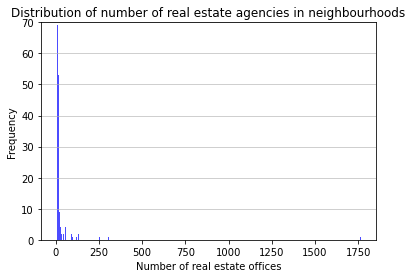

In [25]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=no_estate_offices['Venue'], bins='auto', color='blue',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of real estate offices')
plt.ylabel('Frequency')
plt.title('Distribution of number of real estate agencies in neighbourhoods')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
#plt.xlim([0, 200])

Let's look at how many properties had been sold in each neighbourhood.

In [26]:
pgd=price_geo_data[['postcode','price','Borough','latitude','longitude']]
pgd=pgd.rename(columns={'postcode' : 'Neighbourhood'})
pgd.head()

,Neighbourhood,price,Borough,latitude,longitude
0,EC1Y 0AD,727300,CITY OF LONDON,51.523139,-0.095988
1,EC1Y 0AD,1083750,CITY OF LONDON,51.523139,-0.095988
2,EC1Y 0AD,1066750,CITY OF LONDON,51.523139,-0.095988
3,EC1Y 0AD,1397500,CITY OF LONDON,51.523139,-0.095988
4,EC1Y 0AD,815450,CITY OF LONDON,51.523139,-0.095988


In [27]:
pgd['Neighbourhood'].value_counts().describe()

count    481.000000
mean       2.155925
std        7.400353
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      147.000000
Name: Neighbourhood, dtype: float64

As most neighbourhoods had just one or two property sales, but some had as many as 147 in a year, we are going to use median price as a representation of price point in each neighbourhood.

In [28]:
pgd_median_price= pgd.groupby(['Neighbourhood','Borough']).median().reset_index()
pgd_median_price.head()

,Neighbourhood,Borough,price,latitude,longitude
0,EC1A 2DJ,CITY OF LONDON,14900000.0,51.516995,-0.102727
1,EC1A 4HU,CITY OF LONDON,746000.0,51.518236,-0.097184
2,EC1A 7AB,CITY OF LONDON,649950.0,51.519512,-0.098774
3,EC1A 7BB,CITY OF LONDON,1465000.0,51.517906,-0.098956
4,EC1A 7BD,CITY OF LONDON,1500000.0,51.518864,-0.098559


We are now going to plot the distribution of the median prices to see how skewed the data is.

(0.0, 120.0)

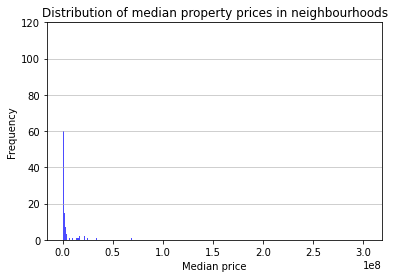

In [30]:
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=pgd_median_price['price'], bins='auto', color='blue',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Median price')
plt.ylabel('Frequency')
plt.title('Distribution of median property prices in neighbourhoods')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
#plt.xlim([0, 200])

We can see that both number of real estate offices dataset and median prices are very skewed. We are going to split both price and number of offices variables into quantiles and use them for modelling to avoid those outliers having too much impact.

In [31]:
no_estate_offices['agencies quantiles range'] = pd.qcut(no_estate_offices['Venue'], q=10, precision=0)
no_estate_offices['agencies quantiles'] = pd.qcut(no_estate_offices['Venue'], q=10, precision=0,labels=False)

eo_quant_range=no_estate_offices[["agencies quantiles range", 'agencies quantiles']].drop_duplicates().sort_values(by=['agencies quantiles'], ascending=True).reset_index(drop=True)
eo_quant_range

,agencies quantiles range,agencies quantiles
0,"(1.0, 7.0]",0
1,"(7.0, 9.0]",1
2,"(9.0, 11.0]",2
3,"(11.0, 12.0]",3
4,"(12.0, 14.0]",4
5,"(14.0, 15.0]",5
6,"(15.0, 17.0]",6
7,"(17.0, 20.0]",7
8,"(20.0, 36.0]",8
9,"(36.0, 1764.0]",9


In [32]:
pgd_median_price['price quantiles range'] = pd.qcut(pgd_median_price['price'], q=10, precision=0)
pgd_median_price['price quantiles'] = pd.qcut(pgd_median_price['price'], q=10, precision=0,labels=False)

pgd_quant_range=pgd_median_price[["price quantiles range", 'price quantiles']].drop_duplicates().sort_values(by=['price quantiles'], ascending=True).reset_index(drop=True)
pgd_quant_range

,price quantiles range,price quantiles
0,"(5132.0, 310000.0]",0
1,"(310000.0, 470000.0]",1
2,"(470000.0, 575000.0]",2
3,"(575000.0, 701112.0]",3
4,"(701112.0, 830000.0]",4
5,"(830000.0, 985000.0]",5
6,"(985000.0, 1320000.0]",6
7,"(1320000.0, 1990000.0]",7
8,"(1990000.0, 7650000.0]",8
9,"(7650000.0, 303470000.0]",9


Let's merge the price data in each neighbourhood with geoloation data and the number of real estate offices nearby.

In [33]:
london_merged = pd.merge(pgd_median_price, no_estate_offices,  how="left", on=['Neighbourhood'])
london_merged # check the last columns!

,Neighbourhood,Borough,price,latitude,longitude,price quantiles range,price quantiles,Venue,agencies quantiles range,agencies quantiles
0,EC1A 2DJ,CITY OF LONDON,14900000.0,51.516995,-0.102727,"(7650000.0, 303470000.0]",9,16,"(15.0, 17.0]",6
1,EC1A 4HU,CITY OF LONDON,746000.0,51.518236,-0.097184,"(701112.0, 830000.0]",4,18,"(17.0, 20.0]",7
2,EC1A 7AB,CITY OF LONDON,649950.0,51.519512,-0.098774,"(575000.0, 701112.0]",3,17,"(15.0, 17.0]",6
3,EC1A 7BB,CITY OF LONDON,1465000.0,51.517906,-0.098956,"(1320000.0, 1990000.0]",7,36,"(20.0, 36.0]",8
4,EC1A 7BD,CITY OF LONDON,1500000.0,51.518864,-0.098559,"(1320000.0, 1990000.0]",7,17,"(15.0, 17.0]",6
...,...,...,...,...,...,...,...,...,...,...
476,WC2R 1HA,CITY OF WESTMINSTER,1569500.0,51.512084,-0.118208,"(1320000.0, 1990000.0]",7,18,"(17.0, 20.0]",7
477,WC2R 1JA,CITY OF WESTMINSTER,1100000.0,51.511471,-0.118233,"(985000.0, 1320000.0]",6,9,"(7.0, 9.0]",1
478,WC2R 3DX,CITY OF WESTMINSTER,1195000.0,51.511505,-0.113562,"(985000.0, 1320000.0]",6,10,"(9.0, 11.0]",2
479,WC2R 3JF,CITY OF WESTMINSTER,1500000.0,51.512940,-0.112840,"(1320000.0, 1990000.0]",7,10,"(9.0, 11.0]",2


## Model Building - KMeans

We will be using KMeans Clustering Machine learning algorithm to cluster similar neighbourhoods together.

We will use KMeans elbows method to select the number of clusters.

In [34]:
london_grouped_clustering=london_merged[['price quantiles','agencies quantiles']]

In [35]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(london_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

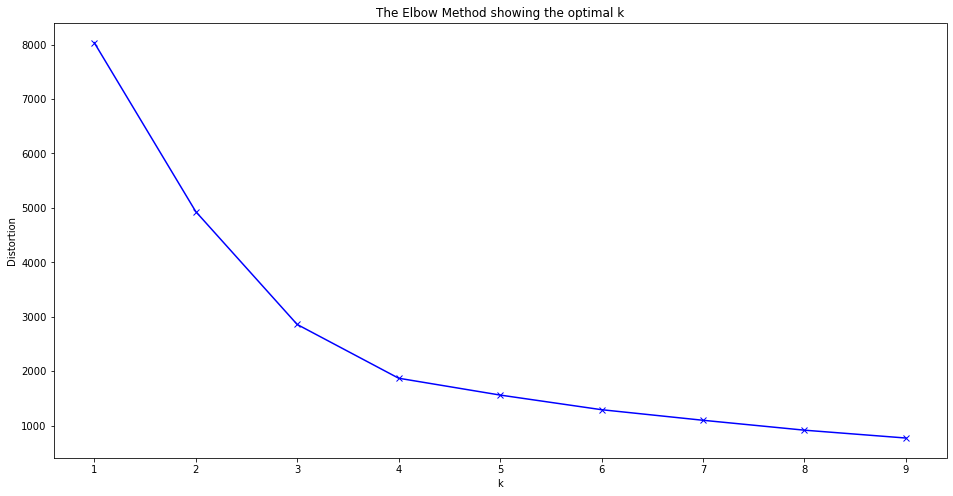

In [36]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method indicates that the optimal number of clusters could be between 4 and 7, so we are going to calculate Silhouette Scores to help us decide.

In [37]:
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    KMean= KMeans(n_clusters=i)
    KMean.fit(london_grouped_clustering)
    label=KMean.predict(london_grouped_clustering)
    print("Silhouette Score for k=", i, "is: ", silhouette_score(london_grouped_clustering, label)) 

Silhouette Score for k= 2 is:  0.3664219055418742
Silhouette Score for k= 3 is:  0.4170669012274279
Silhouette Score for k= 4 is:  0.43639664955339147
Silhouette Score for k= 5 is:  0.4081160096499596
Silhouette Score for k= 6 is:  0.3851527934642992
Silhouette Score for k= 7 is:  0.4104884483411236
Silhouette Score for k= 8 is:  0.39430032515451724
Silhouette Score for k= 9 is:  0.3998430070285899
Silhouette Score for k= 10 is:  0.41133931447238786


Based on the two methods, the optimal number of clusters is 4 in KMeans algorithm.

In [38]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)
kmeans.labels_[:100]

array([2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 2, 0,
       1, 0, 0, 2, 2, 2, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 3, 1, 1,
       3, 3, 3, 1, 1, 1, 0, 3, 1, 0, 1, 1, 1, 2, 1, 2, 0, 1, 2, 2, 3, 1,
       1, 2, 0, 1, 2, 0, 3, 1, 2, 0, 2, 0, 2, 2, 1, 1, 0, 2, 0, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as median prices and the number of real estate offices for each neighbourhood by merging to london_merged.

In [39]:
# add clustering labels
london_merged.insert(0, 'Cluster Labels', kmeans.labels_)

Let's drop all the NaN values for Cluster Labels.

In [40]:
london_merged = london_merged.dropna(subset=['Cluster Labels'])
london_merged.head()

,Cluster Labels,Neighbourhood,Borough,price,latitude,longitude,price quantiles range,price quantiles,Venue,agencies quantiles range,agencies quantiles
0,2,EC1A 2DJ,CITY OF LONDON,14900000.0,51.516995,-0.102727,"(7650000.0, 303470000.0]",9,16,"(15.0, 17.0]",6
1,2,EC1A 4HU,CITY OF LONDON,746000.0,51.518236,-0.097184,"(701112.0, 830000.0]",4,18,"(17.0, 20.0]",7
2,0,EC1A 7AB,CITY OF LONDON,649950.0,51.519512,-0.098774,"(575000.0, 701112.0]",3,17,"(15.0, 17.0]",6
3,2,EC1A 7BB,CITY OF LONDON,1465000.0,51.517906,-0.098956,"(1320000.0, 1990000.0]",7,36,"(20.0, 36.0]",8
4,2,EC1A 7BD,CITY OF LONDON,1500000.0,51.518864,-0.098559,"(1320000.0, 1990000.0]",7,17,"(15.0, 17.0]",6


## Results

Let's visualize the resulting clusters.

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['latitude'], london_merged['longitude'], london_merged['Neighbourhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(int(cluster)+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We have 4 clusters that differentiate neighbourhoods by property prices and density of real estate offices nearby. More information about each cluster is provided below and also visualised in a map of Central London above.

Cluster 1

In [43]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0,1,2,3,8,7,10]]]

,Cluster Labels,Neighbourhood,Borough,price,Venue,price quantiles,agencies quantiles
2,0,EC1A 7AB,CITY OF LONDON,649950.0,17,3,6
8,0,EC1A 7ES,CITY OF LONDON,550000.0,18,2,7
10,0,EC1A 9JR,CITY OF LONDON,562500.0,32,2,8
11,0,EC1A 9LS,CITY OF LONDON,562125.0,32,2,8
12,0,EC1A 9PN,CITY OF LONDON,701112.5,34,3,8
...,...,...,...,...,...,...,...
403,0,WC1X 8SF,CAMDEN,255000.0,20,0,7
430,0,WC2B 6SR,CAMDEN,27500.0,22,0,8
436,0,WC2E 7NU,CITY OF WESTMINSTER,548000.0,18,2,7
446,0,WC2H 7BA,CITY OF WESTMINSTER,20000.0,13,0,4


In [44]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[7,10]]].describe()

,price quantiles,agencies quantiles
count,120.000000,120.000000
mean,1.683333,5.783333
std,1.347162,1.551271
min,0.000000,4.000000
25%,0.000000,4.000000
50%,2.000000,6.000000
75%,3.000000,7.000000
max,4.000000,9.000000


Cluster 2

In [45]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0,1,2,3,8,7,10]]]

,Cluster Labels,Neighbourhood,Borough,price,Venue,price quantiles,agencies quantiles
14,1,EC1M 3JB,CAMDEN,3637000.0,13,8,4
16,1,EC1M 4AJ,ISLINGTON,17600000.0,15,9,5
17,1,EC1M 4DG,ISLINGTON,29600000.0,15,9,5
22,1,EC1M 6EJ,ISLINGTON,13900000.0,15,9,5
30,1,EC1N 8DH,CAMDEN,4050000.0,14,8,4
...,...,...,...,...,...,...,...
473,1,WC2R 0NR,CITY OF WESTMINSTER,3099000.0,11,8,2
477,1,WC2R 1JA,CITY OF WESTMINSTER,1100000.0,9,6,1
478,1,WC2R 3DX,CITY OF WESTMINSTER,1195000.0,10,6,2
479,1,WC2R 3JF,CITY OF WESTMINSTER,1500000.0,10,7,2


In [46]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[7,10]]].describe()

,price quantiles,agencies quantiles
count,130.000000,130.000000
mean,7.415385,2.469231
std,1.345591,1.420713
min,5.000000,0.000000
25%,6.000000,2.000000
50%,8.000000,2.000000
75%,9.000000,4.000000
max,9.000000,5.000000


Cluster 3

In [47]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0,1,2,3,8,7,10]]]

,Cluster Labels,Neighbourhood,Borough,price,Venue,price quantiles,agencies quantiles
0,2,EC1A 2DJ,CITY OF LONDON,14900000.0,16,9,6
1,2,EC1A 4HU,CITY OF LONDON,746000.0,18,4,7
3,2,EC1A 7BB,CITY OF LONDON,1465000.0,36,7,8
4,2,EC1A 7BD,CITY OF LONDON,1500000.0,17,7,6
5,2,EC1A 7BF,CITY OF LONDON,1655000.0,54,7,9
...,...,...,...,...,...,...,...
469,2,WC2N 6LU,CITY OF WESTMINSTER,2750000.0,27,8,8
472,2,WC2R 0JF,CITY OF WESTMINSTER,26410177.0,22,9,8
474,2,WC2R 0PP,CITY OF WESTMINSTER,1108750.0,20,6,7
475,2,WC2R 1AB,CITY OF WESTMINSTER,1712500.0,66,7,9


In [48]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[7,10]]].describe()

,price quantiles,agencies quantiles
count,120.000000,120.000000
mean,6.191667,7.741667
std,1.610344,1.205700
min,3.000000,5.000000
25%,5.000000,7.000000
50%,6.000000,8.000000
75%,7.000000,9.000000
max,9.000000,9.000000


Cluster 4

In [49]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0,1,2,3,8,7,10]]]

,Cluster Labels,Neighbourhood,Borough,price,Venue,price quantiles,agencies quantiles
41,3,EC1R 0DY,ISLINGTON,750000.0,11,4,2
44,3,EC1R 0HA,ISLINGTON,775000.0,10,4,2
45,3,EC1R 0HR,ISLINGTON,10267.0,11,0,2
46,3,EC1R 0JQ,ISLINGTON,800170.0,8,4,1
51,3,EC1R 1XJ,ISLINGTON,655000.0,12,3,3
...,...,...,...,...,...,...,...
462,3,WC2N 5HS,CITY OF WESTMINSTER,59175.0,8,0,1
463,3,WC2N 6AR,CITY OF WESTMINSTER,580000.0,8,3,1
465,3,WC2N 6EG,CITY OF WESTMINSTER,905000.0,8,5,1
466,3,WC2N 6HA,CITY OF WESTMINSTER,790000.0,9,4,1


In [50]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[7,10]]].describe()

,price quantiles,agencies quantiles
count,111.000000,111.000000
mean,2.252252,1.180180
std,1.551940,1.080389
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,3.000000,2.000000
max,5.000000,3.000000


We have successfully clustered Central London neighbourhoods by property prices and density of real estate agencies:
- Cluster 1: Lower prices, high number of agencies
- Cluster 2: High prices, low number of agencies
- Cluster 3: High prices, high number of agencies
- Cluster 4: Low prices, low number of agencies


## Discussion

We tried to find the best area in Central London to open a new luxury real estate agency. Central London is very expensive overall, but some neighbourhoods are more popular than others between real estate companies and property prices vary ar well. In some neighbourhoods, we have more than 1000 real estate offices registered nearby and in some properties might cost tens and hundreds of millions. As such sales are very rare, it's better to concentrate on luxury class expensive property that are not one of a kind to ensure enough volume. We clustered all neighbourhoods based on property prices and number of real estate offices in close proximity using KMeans algorithm. Based on clustering results, the best areas to consider for the new office are in Cluster 2.

## Conclusion

The purpose of this project was to find the best neighbourhood to open a new real estate agency. Even though there are lots of agencies already, there are places that are less dense and it is possible to find a niche to open an exlusive real estate agency and be successful. By combining various data sources and applying K-Means algorithm, we managed to find best areas for a new real estate agency. However, it's up to the stakeholders to decide what other criteria is also important to them. It might be also worth taken into account rental prices in the area and whether there are any other luxury class venues nearby before opening the agency. 